In [1]:
import os,sys
import numpy as np
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu
import PIL
from PIL import Image

Using TensorFlow backend.


In [2]:
import keras
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# Experimenting with images

In [3]:
### Loading saved npy files
# Loading in saved subset of data files 
subsetComplexSignals = np.load('complexSignalsSubset.npy')[()]
subsetSpectrograms = np.load('specSubset.npy')[()]

## Trying out binning techniques

Trying out some code from https://gist.github.com/derricw/95eab740e1b08b78c03f to average along x-axis. 
Also experimenting with reshaping / resizing the image

In [4]:
def showImageFromSpec(spec,imsize,binFactor,save=False,filename=None):
    specShape = spec.shape
    spec = cu.nputils.bin_ndarray(spec[1:,:],(specShape[0]-1,specShape[1]/binFactor),operation='average')
    dpi = 96.0
    fig = plt.figure(frameon=False,figsize=(imsize[0]/dpi,imsize[1]/dpi))
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # fig, ax = plt.subplots(figsize=(20, 10))
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])
    plt.set_cmap('jet')
    ax.imshow(np.log(spec), aspect = 'auto')
    plt.show()

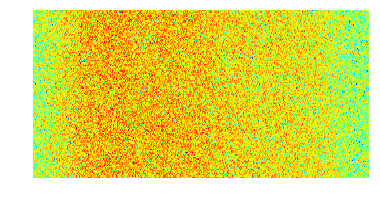

In [5]:
# spec = subsetSpectrograms['narrowband'][1]
# spec = subsetSpectrograms['squiggle'][1]
# spec = subsetSpectrograms['squigglesquarepulsednarrowband'][2]
spec = subsetSpectrograms['squarepulsednarrowband'][0]
showImageFromSpec(spec,(448,224),4,save=False,filename="resized_spec")

In [6]:
np.max(subsetSpectrograms['noise'][1])

31556838.07360312

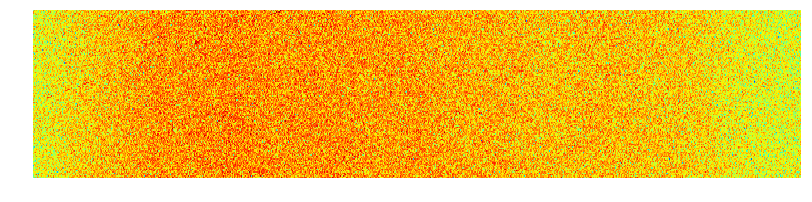

In [7]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 3 to 128x2048
showImageFromSpec(spec,(1024,224),3,save=False,filename="resized_spec")

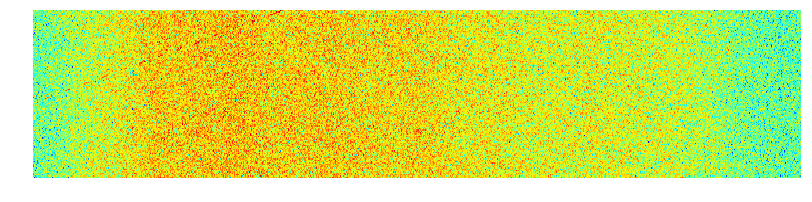

In [8]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 6 to 128x1024
showImageFromSpec(spec,(1024,224),6,save=False,filename="resized_spec")

## Converting all files to images (skip if already exists)

In [9]:
# Run through directory 
specPath = "data/specdataraw/"
binFactor = 3
image_size = (1024,224)
savePath = "data/specdataimages{}x{}_{}/".format(image_size[0],image_size[1],binFactor)
specfiles = [f for f in os.listdir(specPath) if os.path.isfile(os.path.join(specPath, f))]
for i in range(len(specfiles)):
    # Convert and save each file as image
    fname = specfiles[i].split(".")[0]
    print "\r{0}".format(i),
    spec = np.load("{}{}.npy".format(specPath,fname))
    cu.datautils.saveImageFromSpec(spec,image_size,save=True,filename="{}{}".format(savePath,fname))

0

TypeError: saveImageFromSpec() takes at least 3 arguments (4 given)

## Saving a sample of images - to send to Andreas

In [12]:
subsetSpectrograms.keys()

['noise',
 'squiggle',
 'narrowbanddrd',
 'brightpixel',
 'narrowband',
 'squigglesquarepulsednarrowband',
 'squarepulsednarrowband']

In [ ]:
for key in subsetSpectrograms.keys():
    for i in range(len(subsetSpectrograms[key])):
        %%system mkdir -p sampleImages_small_size
        spec = subsetSpectrograms[key][i]
        fname = "./sampleImages_small_size/{}_{}".format(key,i)
        cu.datautils.saveImageFromSpec(spec,(224,224),save=True,filename=fname) # Creating smaller size images!

# VGG Model activations

## Individually examining activations

In [9]:
# Loading in table with info on files
fileListDF = pd.read_csv("fileList.csv")
# Loading in an arbitrary file
imgPath = "data/specdataimages/"
fnum = 40
imgfiles = [f for f in os.listdir(imgPath) if os.path.isfile(os.path.join(imgPath, f))]
image = np.asarray(Image.open(os.path.join(imgPath,imgfiles[fnum])))
print imgfiles[fnum]
print fileListDF.ix[int(imgfiles[fnum].split(".")[0])]

000271.jpg
file_name                03f55ef8-c401-48c5-ac69-db2bdcebe6c3.dat
signal_classification                               narrowbanddrd
uuid                         03f55ef8-c401-48c5-ac69-db2bdcebe6c3
file_index                                                    271
label                                                           3
Name: 271, dtype: object


jet


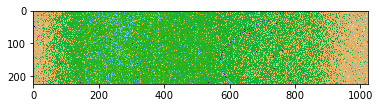

In [10]:
image = image.astype('float32')
image = np.expand_dims(image,axis=0)
image = preprocess_input(image)
print plt.get_cmap().name
plt.imshow(image[0])
plt.show()

(1, 14, 64, 512)
(2, 2)
(2, 2)


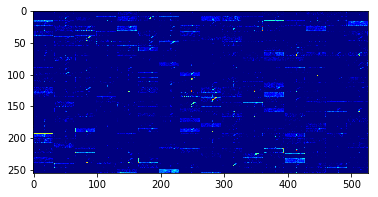

In [12]:
# Loading in the model
base_model = VGG16(weights='imagenet', include_top=False)
# Viewing VGG activations on the entire image 
imageAct = cu.datautils.modelActivations(base_model,'block4_pool',image,poolfit=(7,32),save=True,show=True)

## Generating all activations (skip if already exists)

In [13]:
# Point to directory
# Call model activations function
readDir = "data/specdataimages/"
writeDir = "data/specdataactivations_block4_7_32/"
layerName = "block4_pool"
poolfitSize = (14,32)
cu.datautils.generateAllActivations(readDir,writeDir,layerName,poolfitSize)

File 8 / 15985: 002222.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 16 / 15985: 009659.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 24 / 15985: 015516.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 32 / 15985: 001578.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 40 / 15985: 000271.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 48 / 15985: 012483.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 56 / 15985: 014090.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 64 / 15985: 013717.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 72 / 15985: 005214.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 80 / 15985: 009654.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 88 / 15985: 013259.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 96 / 15985: 006991.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 104 / 15985: 011067.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 112 / 15985: 014956.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 120 / 15985: 012054.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 128 / 15985: 014323.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 136 / 15985: 0126

File 1064 / 15985: 001927.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1072 / 15985: 013813.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1080 / 15985: 003413.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1088 / 15985: 012781.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1096 / 15985: 003487.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1104 / 15985: 011446.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1112 / 15985: 007547.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1120 / 15985: 006163.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1128 / 15985: 000026.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1136 / 15985: 001928.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1144 / 15985: 010851.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1152 / 15985: 013366.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1160 / 15985: 000093.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1168 / 15985: 012547.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1176 / 15985: 014929.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 1184 / 15985: 009765.jpg    (8, 14, 64, 512)
(1, 2)
(1

File 2104 / 15985: 005757.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2112 / 15985: 012841.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2120 / 15985: 015870.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2128 / 15985: 013221.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2136 / 15985: 013898.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2144 / 15985: 008509.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2152 / 15985: 015102.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2160 / 15985: 002988.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2168 / 15985: 011996.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2176 / 15985: 012146.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2184 / 15985: 006079.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2192 / 15985: 007138.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2200 / 15985: 006087.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2208 / 15985: 010457.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2216 / 15985: 014935.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 2224 / 15985: 009168.jpg   (8, 14, 64, 512)
(1, 2

File 3144 / 15985: 013050.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3152 / 15985: 012269.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3160 / 15985: 004579.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3168 / 15985: 003756.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3176 / 15985: 010924.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3184 / 15985: 004513.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3192 / 15985: 012218.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3200 / 15985: 006089.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3208 / 15985: 002093.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3216 / 15985: 008516.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3224 / 15985: 005270.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3232 / 15985: 009305.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3240 / 15985: 014151.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3248 / 15985: 005183.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3256 / 15985: 009657.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 3264 / 15985: 009176.jpg   (8, 14, 64, 512)
(1, 2)


File 4184 / 15985: 011251.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4192 / 15985: 003427.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4200 / 15985: 009101.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4208 / 15985: 004771.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4216 / 15985: 015172.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4224 / 15985: 007843.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4232 / 15985: 014207.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4240 / 15985: 014085.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4248 / 15985: 015197.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4256 / 15985: 003242.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4264 / 15985: 014817.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4272 / 15985: 010597.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4280 / 15985: 004462.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4288 / 15985: 000319.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4296 / 15985: 011145.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 4304 / 15985: 006963.jpg   (8, 14, 64, 512)
(1,

File 5224 / 15985: 005022.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5232 / 15985: 011904.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5240 / 15985: 010611.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5248 / 15985: 005983.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5256 / 15985: 001048.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5264 / 15985: 007977.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5272 / 15985: 006404.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5280 / 15985: 014960.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5288 / 15985: 012107.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5296 / 15985: 003713.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5304 / 15985: 010615.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5312 / 15985: 015140.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5320 / 15985: 007817.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5328 / 15985: 012937.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5336 / 15985: 003821.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 5344 / 15985: 007497.jpg   (8, 14, 64, 512)
(1, 2)


File 6264 / 15985: 006776.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6272 / 15985: 009642.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6280 / 15985: 004171.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6288 / 15985: 000369.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6296 / 15985: 004157.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6304 / 15985: 004041.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6312 / 15985: 006759.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6320 / 15985: 009438.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6328 / 15985: 012367.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6336 / 15985: 003987.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6344 / 15985: 001159.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6352 / 15985: 005584.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6360 / 15985: 003290.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6368 / 15985: 008614.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6376 / 15985: 008031.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 6384 / 15985: 013123.jpg    (8, 14, 64, 512)
(1

File 7304 / 15985: 013455.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7312 / 15985: 003732.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7320 / 15985: 012544.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7328 / 15985: 005100.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7336 / 15985: 010126.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7344 / 15985: 014088.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7352 / 15985: 005410.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7360 / 15985: 015677.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7368 / 15985: 000860.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7376 / 15985: 009076.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7384 / 15985: 007394.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7392 / 15985: 008553.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7400 / 15985: 009471.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7408 / 15985: 013155.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7416 / 15985: 002710.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 7424 / 15985: 013078.jpg   (8, 14, 64, 512)
(1, 2)

File 8344 / 15985: 006802.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8352 / 15985: 000355.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8360 / 15985: 004842.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8368 / 15985: 006553.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8376 / 15985: 001444.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8384 / 15985: 000010.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8392 / 15985: 015517.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8400 / 15985: 000780.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8408 / 15985: 002741.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8416 / 15985: 005166.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8424 / 15985: 011475.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8432 / 15985: 009985.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8440 / 15985: 007562.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8448 / 15985: 012151.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8456 / 15985: 015930.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 8464 / 15985: 000838.jpg  (8, 14, 64, 512)
(1, 

File 9384 / 15985: 009023.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9392 / 15985: 009182.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9400 / 15985: 006827.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9408 / 15985: 007920.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9416 / 15985: 012421.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9424 / 15985: 002784.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9432 / 15985: 005185.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9440 / 15985: 010004.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9448 / 15985: 010008.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9456 / 15985: 012753.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9464 / 15985: 007255.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9472 / 15985: 003227.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9480 / 15985: 008625.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9488 / 15985: 007715.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9496 / 15985: 006289.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 9504 / 15985: 004741.jpg   (8, 14, 64, 512)
(1, 2)


File 10416 / 15985: 005380.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10424 / 15985: 008779.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10432 / 15985: 009881.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10440 / 15985: 006984.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10448 / 15985: 000913.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10456 / 15985: 004750.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10464 / 15985: 000239.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10472 / 15985: 002260.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10480 / 15985: 013935.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10488 / 15985: 007769.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10496 / 15985: 014828.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10504 / 15985: 002012.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10512 / 15985: 008989.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10520 / 15985: 011922.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10528 / 15985: 002449.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 10536 / 15985: 012184.jpg   (8, 14, 64,

File 11440 / 15985: 001147.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11448 / 15985: 002511.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11456 / 15985: 007763.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11464 / 15985: 007303.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11472 / 15985: 005354.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11480 / 15985: 011924.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11488 / 15985: 001950.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11496 / 15985: 001788.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11504 / 15985: 010518.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11512 / 15985: 014057.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11520 / 15985: 007004.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11528 / 15985: 003214.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11536 / 15985: 001784.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11544 / 15985: 014240.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11552 / 15985: 011838.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 11560 / 15985: 007378.jpg   (8, 14, 64

File 12464 / 15985: 002492.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12472 / 15985: 002540.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12480 / 15985: 008038.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12488 / 15985: 008064.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12496 / 15985: 005547.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12504 / 15985: 009259.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12512 / 15985: 001350.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12520 / 15985: 007630.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12528 / 15985: 015391.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12536 / 15985: 008114.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12544 / 15985: 011197.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12552 / 15985: 006319.jpg  (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12560 / 15985: 015623.jpg    (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12568 / 15985: 005560.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12576 / 15985: 008753.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 12584 / 15985: 015043.jpg   (8, 14, 64, 5

File 13488 / 15985: 008475.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13496 / 15985: 014807.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13504 / 15985: 011673.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13512 / 15985: 008827.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13520 / 15985: 015717.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13528 / 15985: 007119.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13536 / 15985: 014216.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13544 / 15985: 014748.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13552 / 15985: 004313.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13560 / 15985: 006947.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13568 / 15985: 009447.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13576 / 15985: 009988.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13584 / 15985: 002534.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13592 / 15985: 008950.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13600 / 15985: 002496.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 13608 / 15985: 004192.jpg   (8, 14, 6

File 14512 / 15985: 011114.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14520 / 15985: 009029.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14528 / 15985: 013914.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14536 / 15985: 004812.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14544 / 15985: 014388.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14552 / 15985: 003880.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14560 / 15985: 003499.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14568 / 15985: 000007.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14576 / 15985: 003000.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14584 / 15985: 001721.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14592 / 15985: 003556.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14600 / 15985: 003367.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14608 / 15985: 000966.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14616 / 15985: 008889.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14624 / 15985: 005579.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 14632 / 15985: 011807.jpg   (8, 14, 6

File 15536 / 15985: 008833.jpg (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15544 / 15985: 015219.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15552 / 15985: 006734.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15560 / 15985: 004325.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15568 / 15985: 015141.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15576 / 15985: 002694.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15584 / 15985: 001612.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15592 / 15985: 009938.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15600 / 15985: 003301.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15608 / 15985: 004162.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15616 / 15985: 006732.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15624 / 15985: 001551.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15632 / 15985: 005752.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15640 / 15985: 007879.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15648 / 15985: 011675.jpg   (8, 14, 64, 512)
(1, 2)
(1, 2)
File 15656 / 15985: 008697.jpg   (8, 14, 6

## Creating combined activations file (skip if done)

In [4]:
fileListDF = pd.read_csv("fileList.csv",dtype={'file_index':str})
fileListDF.groupby("signal_classification").count()

,file_name,uuid,file_index,label
signal_classification,,,,
brightpixel,2000,2000,2000,2000
narrowband,1997,1997,1997,1997
narrowbanddrd,3995,3995,3995,3995
noise,1998,1998,1998,1998
squarepulsednarrowband,1998,1998,1998,1998
squiggle,1997,1997,1997,1997
squigglesquarepulsednarrowband,2000,2000,2000,2000


In [5]:
## Assigning numbers to classes
labelMap = {'noise':0,'brightpixel':1,'narrowband':2,
            'narrowbanddrd':3,'squarepulsednarrowband':4,'squiggle':5,'squigglesquarepulsednarrowband':6}
# fileListDF["label"] = fileListDF["signal_classification"].apply(lambda x: labelMap[x])
# fileListDF.to_csv("fileList.csv",index=False)
print labelMap
fileListDF.ix[0:5]

{'noise': 0, 'squiggle': 5, 'narrowbanddrd': 3, 'brightpixel': 1, 'narrowband': 2, 'squigglesquarepulsednarrowband': 6, 'squarepulsednarrowband': 4}


,file_name,signal_classification,uuid,file_index,label
0,00069203-0824-4136-9c99-b9f68672f23d.dat,squigglesquarepulsednarrowband,00069203-0824-4136-9c99-b9f68672f23d,000000,6
1,000739aa-89d6-4965-abf6-9b46a246604a.dat,narrowband,000739aa-89d6-4965-abf6-9b46a246604a,000001,2
2,000874dd-8d6e-44b1-8ade-21aeb5a29546.dat,narrowbanddrd,000874dd-8d6e-44b1-8ade-21aeb5a29546,000002,3
3,0009073c-4032-4b84-832a-9b81fc3b0df8.dat,brightpixel,0009073c-4032-4b84-832a-9b81fc3b0df8,000003,1
4,000c28b3-aeba-4f18-ac60-b91341921264.dat,squigglesquarepulsednarrowband,000c28b3-aeba-4f18-ac60-b91341921264,000004,6
5,000eb18b-326f-4488-9f07-b7382c01bf91.dat,narrowband,000eb18b-326f-4488-9f07-b7382c01bf91,000005,2


## Combine all activations from folder and save to a file 

In [14]:
## Read in all files from directory and combine them into train/val/test datasets
readDir = "data/specdataactivations_block4_7_32/"
nvalidation = 3000
ntest = 1500
cu.datautils.createActivationsDataset(readDir,"fileList.csv",nvalidation,
                                      ntest,'data/activations-5-6-block4.h5')

Picking files of extension npy
The number of files is 15984
Training set 11484 / 11484                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

MemoryError: 

In [15]:
dataset.keys()

NameError: name 'dataset' is not defined